# Part I : Quel(le) data scientist êtes-vous ?
## Contexte de l’analyse

Elu métier le plus sexy par la Harvard Business Review en octobre 2012, le data scientist représente un profil rare qui exige de nombreuses compétences.

A partir d'un dataset Aquila, vous réaliserez :
- un clustering non supervisé afin d'identifier 2 groupes de profils techniques distinctes
- une prédiction des profils dont le métier n'est pas labellisé


## Données
data.csv contient 6 variables : 
    - 'Entreprise' correspond à une liste d'entreprises fictive
    - 'Metier' correspond au métier parmi data scientist, lead data scientist, data engineer et data architecte
    - 'Technologies' correspond aux compétences maîtrisées par le profil
    - 'Diplome' correspond à son niveau scolaire (Bac, Master, PhD,...)
    - 'Experience' correspond au nombre d'années d'expériences
    - 'Ville' correspond au lieu de travail
    


## Répondez aux questions 

Bonne chance!

In [1]:
# Import des libraries classique (numpy, pandas, ...)
import pandas as pd
import numpy as np
import re
import sklearn as sk
import seaborn as sb
from matplotlib import pyplot as plt
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, silhouette_score, confusion_matrix
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
%matplotlib inline
plt.style.use('ggplot')


### 1) Importer le tableau de données dans un dataframe 

Il est interessant ici d'ouvrir au préalable le fichier csv avec un logiciel comme<br>
<b>notepad++</b> afin de voir les specificités du document (separateur, etc....).

In [2]:
# Import du dataframe "data.csv"
filename = 'data.csv'
df = pd.read_csv(filename, sep=',', decimal=',')

### 2) Combien y a t-il d'observations dans ce dataset? Y a t-il des valeurs manquantes? 

In [3]:
# methode: avec shape
message = 'methode: nombre d\'observations du dataset {} \n'
print(message.format(df.shape[0]))


methode: nombre d'observations du dataset 9582 



In [4]:
## Apercu des valeurs manquantes
## Calculons la proportion de valeurs manquantes dans chacune des columnes
print('proportion des valeurs manquantes dans chacune des columnes en %: \n')
print(df.isnull().mean()*100)

proportion des valeurs manquantes dans chacune des columnes en %: 

Entreprise      0.177416
Metier          0.198288
Technologies    0.000000
Diplome         0.000000
Experience      0.981006
Ville           0.000000
dtype: float64


<br> Concernant les valeurs manquantes, je constate que les variables categorielles <b> Entreprise</b>, <b>Metier</b> en contiennent approximativement et respectivement <b>0.17%</b> et <b>0.18%</b> tandis que la variable numerique <b>Experience</b> en contient moins de <b>1%</b>.
<br> Ces donnees manquantes sont assez rares (moins de 1%) en general, le dataset est donc exploitable et on peut remplacer ces valeurs manquantes par diverses méthodes (moyenne, medianne, mode (pour les variables categorielles)

### 3) Réaliser l'imputation des valeurs manquantes pour la variable "Experience" avec : 
- la valeur médiane pour les data scientists
- la valeur moyenne pour les data engineers

In [5]:
def making_imputation(dataframe, value, method):
    '''
    INPUT
    -dataframe: dataframe where we did imputation
    - value: value in Experience (Data scientist,etc ...)
    - method : method of imputation
    OUTPUT
    - return new dataframe with replaced values
    
    '''
    
    # faire une copie du dataset
    df = dataframe.copy()
    #faire des verifications quant aux entrees
    message1 = 'valeur non presente dans Experience'
    message2 = 'méthode inconnue'
    assert value in np.unique(df.Metier.dropna()), message1
    assert method in ['mean', 'median'], message2
    # rechercher les indices qui satisfassent la condition
    indices = np.where((df.Metier==value) & (df.Experience.isnull()))[0]
    # la methode de remplacement 
    if method=='mean':
        moyenne = round(np.mean(df.Experience.iloc[np.where(df.Metier==value)]), 2)
        df.loc[indices, 'Experience'] = moyenne
    elif method=='median':
        moyenne = round(np.mean(df.Experience.iloc[np.where(df.Metier==value)]), 2)
        df.loc[indices, 'Experience'] = moyenne
        
    return df
## Remplacer les valeurs manquantes pour les data scientists par la valeur mediane
df = making_imputation(df,'Data scientist', 'median')
## Remplacer les valeurs manquantes pour les data engineers par la moyenne
df = making_imputation(df, 'Data engineer', 'mean')

In [6]:
df

,Entreprise,Metier,Technologies,Diplome,Experience,Ville
0,Sanofi,Data scientist,Matlab/Python/Pyspark/Scikit-learn/Tensorflow,Master,1.00,Paris
1,Massachusetts General Hospital(MGH),Data architecte,Python/Java/Scala/MongoDB,Master,3.00,Marseille
2,Delve,Lead data scientist,SPSS/SQL/Teradata/R/Python/Tensorflow/scikit-l...,Master,3.00,Nantes
3,Ann & Robert H. Lurie Children’s Hospital of C...,Data scientist,C/C++/Java/Python,Master,1.50,Marseille
4,Arm,Data scientist,Matlab/Python/C++/numpy/Tensorflow/scikit-learn,Phd,2.24,Bordeaux
5,S&P Global Ratings,Lead data scientist,VBA/Python/Excel/R,Master,6.00,Lille
6,NVIDIA,Data scientist,Excel/VBA/R/Python/PySpark,Bachelor,0.00,Lille
7,Cedars-Sinai Medical Center,Data scientist,Java/C/C++/R/Python,Bachelor,4.00,Toulouse
8,Fibroblast,Data architecte,Java/Linux/Docker,Bachelor,8.00,Paris
9,General Motors,Data engineer,Python/Java/Linux/GNU,Master,5.00,Toulouse


La méthode que j'ai employee ici, consiste d'abord a detecter <b> les indices </b> du dataset correspondant aux differents emplois qu'on recherche ici, à savoir <b> data scientist </b> et <b> data engineers </b>.
<br> Ensuite nous allons proceder à la modification des <b> NaN </b> presents à ces ligne par les valeurs demandées.
<br> J'utiliserai ici compte tenu de la taille du dataset (moins de 10.000 lignes) les fonctions de <b>numpy</b> qui donnent de meilleurs performances comparativement à celles de <b>pandas</b>.

### 4) Combien d'années d'expériences ont, en moyenne, chacun des profils : le data scientist, le lead data scientist et le data engineer en moyenne?

In [7]:
# Calcul des annees d'experiences de chacun des profils
print('Moyenne des experiences des differents metiers \n {}'.\
      format(round(df.groupby('Metier')['Experience'].mean(), 2)))


Moyenne des experiences des differents metiers 
 Metier
Data architecte        3.00
Data engineer          2.98
Data scientist         2.24
Lead data scientist    3.97
Name: Experience, dtype: float64


<b> Le data scientist </b> a en moyenne <b>3.0 annees </b> d'experiences. <br>
<b> Le lead data scientist </b> a en moyenne <b>3.97 annees </b> d'experiences. <br>
<b> Le data engineer </b> a en moyenne <b>2.98 annees </b> d'experiences.

### 5) Faire la représentation graphique de votre choix afin de comparer le nombre moyen d'années d'expériences pour chaque métier

Text(0.5, 1.0, "Annee d'experiences de divers acteurs de la data")

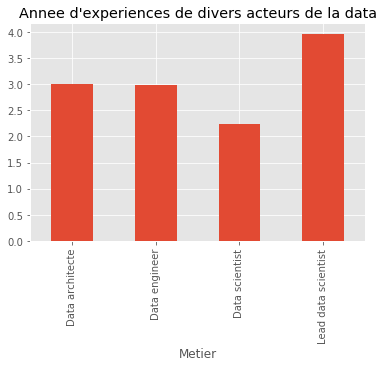

In [11]:
df.groupby('Metier')['Experience'].mean().plot(kind='bar')
plt.title('Annee d\'experiences de divers acteurs de la data')

### 6) Transformer la variable continue 'Experience' en une nouvelle variable catégorielle 'Exp_label' à 4 modalités: débutant, confirmé, avancé et expert
- Veuillez expliquer votre choix du règle de transformation.  

Verifions s'il reste encore des <b>NaN</b> dans la variable <b>Experience</b>

In [13]:
#Verifions s'il reste encore des NaN dans experience
df.isnull().mean()*100

Entreprise      0.177416
Metier          0.198288
Technologies    0.000000
Diplome         0.000000
Experience      0.438322
Ville           0.000000
dtype: float64

Il reste encore <b>0.43%</b> de NaN dans experience, certainement du aux valeurs dans Lead data scientist et lead architect qu'on a pas modifié.
<br> Afin de transformer la variable categorielle, nous allons aussi proceder à l'imputation de ces <b>NaN</b> avec
la mediane, plus robuste aux valeurs abberantes

In [14]:
## Remplacer les valeurs manquantes pour les data architectes par la valeur mediane
df = making_imputation(df,'Lead data scientist', 'median')
## Remplacer les valeurs manquantes pour les lead data scientist par la moyenne
df = making_imputation(df, 'Data architecte', 'median')

<b> Explication de la methode de transformation </b>

La categorisation d'une variabe continue s'accomapagne toujours d'une perte d'informations mais elle peut accelerer et ameliorer les performances du modèle predictif.
<br> J'envisageais deux methodes, en utilisant les fonctions <b>cut</b> et <b>qcut</b>.
<br> La fonction qcut est base sur les quantiles et subdivise la variable continue en clusters irregulierement espacé mais contenant a peu près le meme nombre d'individu.
<br> La méthode cut quant à elle créer des clusters successifs mais ne contenant pas forcement le meme nombre d'individus. Cette méthode nous parait plus réaliste.
<br> Une dernière méthode consisterait ici à utiliser des connaissances à priori pour effectuer cette classfication.
    <br> Nous choisissons ici d'uliser la méthode <b> qcut </b> de pandas plus adapté à notre problematique;

In [34]:
### Realisons ala categorisation avec la methode cut
df['Exp_label'] = df.groupby('Metier')['Experience'].apply(lambda x:pd.cut(x, bins=4,\
                  labels=["debutant", "confirme", "avance", "expert"]))

Plutot que de categoriser ici de manière generale, nous allons créer les categories en fonctions du métier.

Text(0.5, 1.0, 'repartition des categories')

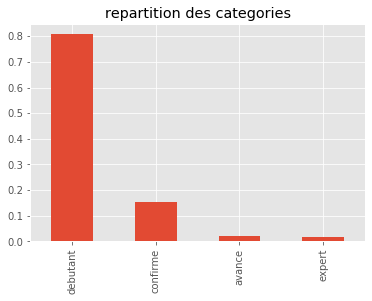

In [36]:
(df.Exp_label.value_counts()/df.shape[0]).plot(kind="bar")
plt.title('repartition des categories')

### 7) Quelles sont les 5 technologies les plus utilisées? Faites un graphique

Listons l'ensemble des technologies utilisées par l'ensemble des candidats

Regardons si sur chaque ligne, chaque observation ne contient pas une technoogie en double ce qui peut fausser le calcul du decompte.
<br> On se sert de set pour faire le compte des technoogies uniques et nous verifions si ce compte est egale à celle de la liste de depart si oui il n'ya pas de double sinon il y'en a

#### Visualisons la liste unique de l'ensemble des technologies

Plusieurs choses sont a noter après visualisation de la colonne <b> Technologie</b> : 
<br> L'anglais n'est pas une technologie donc n'a theoriquement pas sa place parmi les technologies
<br> Des technologies comme <b> Scikit learn </b> sont mentionnés en double a cause des majuscules
<br> Machine learning, big data, map reduce sont des domaines et un paradigme pour le dernier et non pas des technologies au sens propre
<br> <b> Solutions envisagees </b>
<br> <b>1.</b> Mettre en miniscule dans le dataset pour eviter les doublons
<br> <b>2.</b> Pour le listings des 5 technologies les plus utilisees enlever l'Anglais du dataset ainsi que les termes se referant vaguement au domaine (Machine learning, big data, deep learning, scoring).
<br> <b>3.</b> Aussi les termes Hadoop(HDFS) et Hadoop se referent à l'utilisation de la technologie Hadoop. Il y'a donc possibilite de les regrouper. De meme HDFS est le systeme de fichier de Hadoop donc se refère à cette technologie.


In [76]:
# mettre en miniscule les technologies en creant une nouvelle variable Technologies_reelles
df['Technologies_reelles'] = df.Technologies.transform(lambda x:x.lower())
# Remplacons les termes Hadoop(HDFS), HDFS et Hadoop par un unique terme hadoop
df.Technologies_reelles = df.Technologies_reelles.transform(lambda x:re.sub('(.+\(hdfs\)|hdfs)','hadoop',x))
# Enlevons de la liste des technoloiges les termes anglais, machine learning, big data, deep learning, scoring
df.Technologies_reelles = df.Technologies_reelles.transform(lambda x:re.sub('(anglais|big data|machine learning|deep learning|scoring|ai|map-reduce)','',x))
# creeons un dataset avec chacune des technologies comme columne
mlb = MultiLabelBinarizer()
technologies = pd.DataFrame(mlb.fit_transform(df.Technologies_reelles.str.split('/')),columns=mlb.classes_, index=df.index)
#enlever la columne nulle
technologies = technologies.drop('', axis=1)
#verifions si une technologie n'est pas presente 2 fois sur une meme ligne
####### ecrire le code
# mettre en minuscule le texte
technologie_count = technologies.agg('sum').sort_values(ascending=False)

In [77]:
message = 'les 5 technos les plus utilisees sont {}'
print(message.format(technologie_count.index.values[0:5]))

les 5 technos les plus utilisees sont ['python' 'r' 'sql' 'hadoop' 'java']


Cette liste me parait convenable au vu de la definition de technologies et logiciels meme si certains termes peuvent être regrouper ensemble comme python et ses librairies ou la question qu'il aurait à poser est 
qu'es ce la maitrise de python?
<br> Nous allons evoluer avec cette liste

In [ ]:
def plotting_most_used_technologies(number, liste_technologies):
    """
    INPUT
    number : number of technologies
    liste_technologies : liste des technologies
    OUTPUT
    return the number most used technologies
    """
    
    # faire le decompte des technologies individuelles dans la  liste
    techno_names, techno_count = np.unique(liste_technologies, return_counts=True)
    # Avoir les index des "number" technologies les plus utilisees
    n_used_techno_index = np.argsort(techno_count)[-number:]
    # Avoir les noms de ces technologies
    n_used_techno_names = techno_names[n_used_techno_index]
    # Regrouper toutes les autres technologies dans une grosse categorie appelee Autres
    n_used_techno_count = techno_count[n_used_techno_index]
    n_used_techno_count = np.append(n_used_techno_count, 
                                    len(liste_technologies)-sum(n_used_techno_count))

    n_used_techno_names = np.append(n_used_techno_names, "Autres technos") #rajouter les autres qu'on a pas comptabiliser
    explode = np.zeros(number)
    explode[0:number-1] = 0.1
    explode = tuple(explode)
    fig1, ax1 = plt.subplots()
    ax1.pie(n_used_techno_count, labels=n_used_techno_names, autopct='%1.1f%%',
            shadow=True, startangle=180)
    ax1.axis('equal')
    ax1.set_title(str(number)+' technos les plus utilisees')
    plt.show()



##### Tracer un histograme horizontale
def plot_horizontal_histogram(list_of_elements, elt):
    """ INPUT
    - list of elements to plot
    -list of elements to highlight
    OUPUT
    -horizontal bar chat
    """
    dataframe = pd.DataFrame(data=liste_des_logiciels_utilises, columns=['liste_elements'])
    liste_elements = dataframe['liste_elements'].\
                     value_counts(normalize=True, sort=True, ascending=False)[:elt].index
    dataframe[~dataframe.liste_elements.isin(liste_elements)] = 'Autres technos' 
    ax = sb.barplot(x=dataframe['liste_elements'].value_counts(normalize=True, sort=True, ascending=False)[:elt+1].values, 
                y=dataframe['liste_elements'].value_counts(normalize=True, sort=True, ascending=False)[:elt+1].index)
    plt.title(str(elt)+' technos les plus utilisees')

nombre_technos = 5
plotting_most_used_technologies(nombre_technos, liste_des_logiciels_utilises)
plot_horizontal_histogram(liste_des_logiciels_utilises, nombre_technos)

Conclusion <br>Comme on peut le constater sur le camembert et le barchart <br> Python vient en première position des languages utilisés  par les personnes de la data avec un score de <b>15.3%</b>, suivi de près par le langage R, prisée des statisticiens <b>10.0%</b>, Ensuite viennent des outils de gestion et de requetage de la donnee comme SQL <b>5.9%</b>, Hadoop <b>3.6%</b>. <br> Java lui est moins utilisé comparé à Python et R, cela peut être lié au fait que les outils orientés Machine Learning sont plus rares ou moins vulgarisés (prisés)
<br> Ces scores representent les taux par rapport à l'ensemble des logiciels mentionnes. Nous nous sommes assurés que chaque observation ne contient aucun doublon. <br> Les <b>N+1</b> dernières technologies ont été rangés dans <b> Autres technos </b>.

### 8) Réaliser une méthode de clustering non supervisée de votre choix pour faire apparaître 2 clusters que vous jugerez pertinents. Donnez les caractéristiques de chacun des clusters.
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

#### 8.1 Le clustering que nous allons realisé ici vise à faire apparaitre deux groupes de profils techniques distincts
<br> A cet effet, l'entreprise, le metier, l'experience ne sont pas à mon avis des variables essentielles
<br> Nous allons creer des <b>dummies variables</b> avec la variable <b>Technologies_reelles</b>. A cela nous ajouterons le diplome qui est aussi determinant pour connaitre les profils techniques.
<br> A cet effet, nous utiliserons un autre dataset que nous nomerons <b> profil_technique</b>

In [78]:

technologie_reelle = pd.DataFrame(mlb.fit_transform(df.Technologies_reelles.str.split('/')),columns=mlb.classes_, index=df.index)
technologie_reelle = technologie_reelle.drop('',axis=1)#element non desire issu du split
metiers = pd.get_dummies(df.Metier)
experiences = pd.get_dummies(df.Exp_label)
profil_technique = pd.concat([technologie_reelle, metiers, experiences], axis=1)

Il s'agira ici de remplacer toute les variables categorielles par des variables numeriques avec le one hot encoding. 
On peut supprimer la variable metier pour cette etude, par ce que le metier correspont approximativement a une certaine categorie de competences techniques plus ou moins defini, l'entreprise aussi ne semble pas être une variable pertinente, de meme que la ville ou l'emploi est effectué
Le nombre d annee d experience peut definir un profil technique on va get dummies la variable cree

### Reduction de la dimensionnalite concernant les technologies

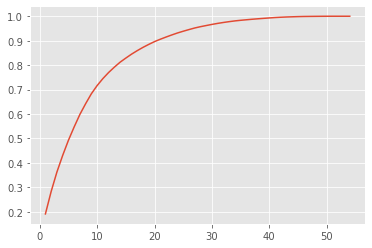

In [79]:
percentage_variance_explained = []
for elt in range(1,profil_technique.shape[1]):
    tsvd = PCA(n_components=elt)
    X =  tsvd.fit_transform(profil_technique)
    percentage_variance_explained.append(tsvd.explained_variance_ratio_[0:elt].sum())
 
plt.plot(list(range(1, profil_technique.shape[1])), percentage_variance_explained)

In [80]:
from sklearn.decomposition import TruncatedSVD

number_of_components = 25
tsvd = PCA(n_components=number_of_components)
software_maitrise_to_take =  tsvd.fit_transform(profil_technique)
print('pourcentage explique {} \n'.format(tsvd.explained_variance_ratio_[0:number_of_components].sum()))
 

pourcentage explique 0.9387028038529633 



#### Utilisation du KMean

In [81]:
kmeans = KMeans(init='k-means++', n_clusters=2, n_init=10)
preds_kmean = kmeans.fit_predict(profil_technique)
clustering_validity = silhouette_score(profil_technique, preds_kmean)
print('avant reduction dimensionnalite {} \n'.format(clustering_validity))

kmeans2 = KMeans(init='k-means++', n_clusters=2, n_init=10)
preds2_kmean = kmeans.fit_predict(software_maitrise_to_take)
clustering_validity2 = silhouette_score(software_maitrise_to_take, preds2_kmean)
print('apres reduction dimensionnalite {} \n'.format(clustering_validity2))
#creation d'une columne pour le resultat de prediction
df['profil_technique_kmean'] = preds2_kmean

avant reduction dimensionnalite 0.18727987328240925 

apres reduction dimensionnalite 0.19867763861254475 



In [82]:
groupe_0 = df[df.profil_technique_kmean==0]
groupe_1 = df[df.profil_technique_kmean==1]
liste_logiciel_0, liste_des_logiciels_utilises_0 = get_list_of_technologies(groupe_0, 'Technologies_reelles', '/')
liste_logiciel_1, liste_des_logiciels_utilises_1 = get_list_of_technologies(groupe_1, 'Technologies_reelles', '/')
plotting_most_used_technologies(5, liste_des_logiciels_utilises_0)
plotting_most_used_technologies(5, liste_des_logiciels_utilises_1)

NameError: name 'get_list_of_technologies' is not defined

In [ ]:
kmeans = AgglomerativeClustering(n_clusters=2)
preds_agglomerative = kmeans.fit_predict(profil_technique)
clustering_validity = silhouette_score(profil_technique, preds_agglomerative)
print('avant reduction dimensionnalite {} \n'.format(clustering_validity))

kmeans2 = AgglomerativeClustering(n_clusters=2)
preds2_agglomerative = kmeans2.fit_predict(software_maitrise_to_take)
clustering_validity2 = silhouette_score(software_maitrise_to_take, preds2_agglomerative)
print('apres reduction dimensionnalite {} \n'.format(clustering_validity2))

# creation d'une columne pour le resultat de prediction
df['profil_technique_agglomerative'] = preds2_agglomerative

In [ ]:
groupe_0 = df[df.profil_technique_agglomerative==0]
groupe_1 = df[df.profil_technique_agglomerative==1]
liste_logiciel_0, liste_des_logiciels_utilises_0 = get_list_of_technologies(groupe_0, 'Technologies_reelles', '/')
liste_logiciel_1, liste_des_logiciels_utilises_1 = get_list_of_technologies(groupe_1, 'Technologies_reelles', '/')
plotting_most_used_technologies(5, liste_des_logiciels_utilises_0)
plotting_most_used_technologies(5, liste_des_logiciels_utilises_1)

La qualité du clustering est assez <b> faible </b> et ce malgré la reduction de dimensionnalité qui ameliore ici sensiblement le resultat.


##### Essayons de trouver à quoi corresponde  ces clusters en terme de denomination metier
Je pars de l'hypothèse que le clustering a separer les données en 2 en procedant ainsi,
d'une part les data scientist qui sont charger à partir des données, de les analyser, de les pré traiter et de mettre en place des modèles et d'autres part les autres acteurs de la data à savoir les data architectes et les data engineer qui eux mettre en place des moyens afin d'avoir des données propres, accessibles et exploitables.


In [ ]:
# Decouvrons la composition des differents groupes en terme de metier
df.groupby('profil_technique_kmean')['Metier'].value_counts()

In [ ]:
# Decouvrons la composition des differents groupes en terme de metier
df.groupby('profil_technique_agglomerative')['Metier'].value_counts()

<b> Notre hypothèse de départ  </b> se voit confirmer
Dans un groupe on a les scientist (data scentist et ead data scientist) et dans 
l'autre des specialistes de la donnee( data architecte et data engineer)
##### qualite du clustering
La faible qualité du clustering s'explique par  le fait que les clusters crées partagent bon nombre d'elements en commun ( de soft skills) comme <b>python</b> (technologie qui apparait en premier dans les deux groupes) ce qui fait qu'il sont difficilement separable.
Aussi, un data scientist peut très bien s'occuper du recueil de la donnée en utilisant les technologies adequates (SQL etc...) pendant que d'autres ne le font pas, ce qui rend la separation entre ces deux classes très difficile.


### 9) Réaliser la prédiction des métiers manquants dans la base de données par l'algorithme de votre choix
-  Justifier la performance de votre algorithme grace à une métrique.
-  Interpréter votre resultat.  

##### Creation de variable interessantes
Creer une variable qui va dire si l'individu en question a fait de longues etudes ou pas <br> <b> longue etudes:</b> (BAC+5 et plus).


In [ ]:
def higher_ed(value):
    if value =='Phd':
        return 'Tres'
    elif value=='Master':
        return 'Classique'
    else:
        return 'Low'

    
df['Hautes_etudes'] = df.Diplome.apply(higher_ed)

In [ ]:
# recuperons les index avec valeurs manquantes de la columne 'Metier'
metiers_manquant = df[pd.isnull(df.Metier)]
index_metiers_manquants = np.asarray(metiers_manquant.index)

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MultiLabelBinarizer

# definition de quelques classes qui me seront utiles

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, attribute_names):
        return self
    def transform(self, X):
        encoder = OneHotEncoder()
        X = pd.get_dummies((X[self.attribute_names]))
        print(X.columns)
        return X

class MultiLabelDataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, attribute_names):
        return self
    def transform(self, X):
        mlb = MultiLabelBinarizer()
        X = pd.DataFrame(mlb.fit_transform(X[self.attribute_names].str.split('/')), columns=mlb.classes_)
        # enlever la colonne avec '' lie au split
        X = X.drop('', axis=1)
        print(X.columns)
        return X


In [ ]:
#definition de quelques fonctions qui me seront utiles
def dummies_categorical_var(single_label_list, multi_label_list,
                            dataframe):
    """
    create dummies variables from categorical
    INPUT
    -single_label_list: column with unique label per row
    -multi_label_list : column with multiple label per
                        row
    -dataframe: dataframe with all this columns
    OUTPUT
    -return a dataframe with dummies variables
    """
    # mettre en place les controles
    
    # mettre en place des pipelines de donnees en s'appuyant sur le typage
    # canard du Pipeline de sklearn
    pipeline_mono = Pipeline([('one_hot_encoding', DataFrameSelector(single_label_list))])
    pipeline_multi = Pipeline([('multi_label_encoding', MultiLabelDataFrameSelector(multi_label_list))])
  
    finale_pipeline = FeatureUnion(transformer_list=[('simple_hot_encoding', pipeline_mono),
                                                 ('multi label encoding', pipeline_multi),
                                                ])

    # convertir les variables en valeurs numeriques
    numerique_df = finale_pipeline.fit_transform(df)
    
    # Retirons les variables caracteeristiques avec le metier manquant
    metier_manquant = numerique_df[index_metiers_manquants, :]

    # Supprimons ces lignes de notre dataset
    numerique_df = np.delete(numerique_df, index_metiers_manquants, axis=0)
    
    return numerique_df, metier_manquant

def diviser_dataset(dataframe, numerique_df, ratio_test, column_to_predict):
    """
    diviser le dataset en un jeu de d'apprentissage
    et un jeu de test.
    -dataframe : le dataset en question avec des variables
                 categorielles
    - dataframe_2 : dataframe avec OneHotEncoding des 
                    variables categorielles
    - ratio_test: le ratio a attribuer 
                  à l'apprentissage
    column_to_predict : columne que l'on veut 
                        pouvoir predire
    """
    # mettre en place les garde fou
    
    # supprimer de la columne à predire les valeurs NaN
    df_base = df.dropna(subset=[column_to_predict], how='any').reset_index()
    
    # on va ici diviser le dataframe en 80% pour l'apprentissage et 20% pour le test
    split = StratifiedShuffleSplit(n_splits=1, test_size=ratio_test, random_state=42)
    for train_index, test_index in split.split(df_base, df_base.Metier):
        strat_train_set = numerique_df[train_index, :]
        strat_test_set = numerique_df[test_index, :]
    strat_train_set = np.column_stack((strat_train_set, df_base.loc[train_index,'Experience']))
    strat_test_set = np.column_stack((strat_test_set, df_base.loc[test_index,'Experience']))
    # recuperons les variables cibles
    y_train_set = df_base.loc[train_index, column_to_predict]
    y_test_set = df_base.loc[test_index, column_to_predict]
    
    return strat_train_set, y_train_set, strat_test_set, y_test_set


def evaluate_random_forest_performance(grid_search, diff_jeu):
    """evaluer un modele de random forest pour la prediction
       en selectionnant le meilleur jeu d'hyperparametres
       possibles
       INPUT
       -grid_search : ensemble des parametres grid search
       - diff jeu : tuple contenant le jeu d'apprentissage,
                    le label d'apprentissage, le jeu de test
                    et les labels de test.
       OUTPUT
       - print the prediction on the test set
       - return a the confusion matrix
    """
    model = RandomForestClassifier()
    strat_train_set = diff_jeu[0] # jeu d'entrainement
    y_train_set = diff_jeu[1] # label d'entrainement
    strat_train_set = diff_jeu[2]
    y_train_set = diff_jeu[3]
    # faire une recherche des meilleurs hyperparametres avec une cross validation de 5
    rf_random = GridSearchCV(estimator = model, param_grid = grid_search, cv = 5, verbose=2, n_jobs = -1)
    # entrainer l'arbre de foret aleatoires
    rf_random.fit(strat_train_set, y_train_set)
    # selectionner le meilleur modele à l'issu du GridSearchCV
    chosen_model = rf_random.best_estimator_
    # score du meilleur modele sur le jeu de validation
    print('score du meilleur modele sur le jeu de validation {}% \n'.format(rf_random.best_score_*100))
    # prediction on test_set
    prediction_test_set = chosen_model.predict(strat_test_set)
    print('accuracy on test set : {}% \n'.format(accuracy_score(y_test_set, prediction_test_set)*100))
    confusion_matrice = confusion_matrix(y_test_set, prediction_test_set, labels=list(np.unique(y_test_set)))
    return chosen_model, confusion_matrice

def prediction_metier_manquants(metier_manquant, attribute_array, chosen_model):
    """
    predire les metiers manquants
    INPUT
    -attribute_array : jeu de donnees ne contenant que les 
                 metiers manquants
    - chosen_model : modele de prediction charge 
                     d'effectuer la prediction
    OUTPUT
    dataset with column 'metiers_predit' qui correspond
    a la prediction qui a ete faite
    """
    metiers_a_predire = metier_manquant.copy()
    #rajout de la columne experience
    attribute_array = np.column_stack((attribute_array, metiers_a_predire.loc[:,'Experience']))
    # prediction avec le modele des classes manquantes
    pred_classes_manquantes = chosen_model.predict(attribute_array)
    # ajouter dans le dataset les metiers predits
    metiers_a_predire.insert(2,'Metiers_predits', pred_classes_manquantes)
    # re ordonner les index du dataset
    metiers_a_predire = metiers_a_predire.reset_index()
    return metiers_a_predire


#### Choix de l'algorithme de classification
Pour le choix de l'algorithme de classification, nous allons ici directement utiliser l'artillerie lourde et 
selectionner un algorithme de type ensembliste type <b> random forest </b>.
<br> Ce choix se justifie notamment par le fait que l'erreur commise lors d'une tache de classification se decompose en deux.
D'une part une <b>erreur bayesienne</b> lie a la distribution des classes et la structure conditionnelle du problème irreductible et une  deuxieme erreur dite <b>ajoutee</b> lié au classifieur qu'on choisie.
Mettre ensemble plusieurs algorithmes de machine learning qui se corrige les uns les autres ou une decision est prise sur l'ensemble des reponses fournie (à la fin pour les <b> random forest </b> et au debut pour les algo du type <b> xgboost </b>) permet d'apporter une robustesse et une justesse supplementaire à la reponse.
<br> <br> Le choix de <b> GridSearchCV </b> par rapport à <b> RandomizedGridSearchCV </b> se justifie ici par la taille du dataset, assez petit et par les capacités de ma machine. 
<br> Bien vrai que le <b> RandomizedGridSearch </b> s'effectue plus rapidement, il donne de moins bon resultats en general sur de petit dataset.
<br> <br> On s'appuie sur le typage <b> canard </b> des transformateurs pipeline pour en creer des customiser
et transformer nos variables categorielle en variable numerique

<br> L'emploi du <b> StratifiedShuffleSplit </b> est préferé ici à un simple <b> train_test_split </b> pour ne pas créer de biais dans les données d'apprentissage.
<br> En effet un tirage purement aleatoire pourrait sous representer ou sur representer une classe dans le jeu d'apprentissage par rapport au jeu de depart ce qui poserait des problemes pour la phase de test.
<br> <br> Dans les differents dataset d'entrainement et de test, nous allons proceder à la transformation des variables categorielles en dummies.
<br> On l'a deja plus haut pour les variables <b> Exp_label</b>, <b>Diplome</b> <b>Metier</b> et <b>Technologies_reelles</b>
<b> La ville et l'entreprise </b> ne definissent à priori pas le metier mais nous allons les laisser dans un premier temps et observer les performances du modèle.

In [ ]:
# tester avec un ensemble de variable qui me semblent pertinente compte tenu de la classification
# à effectuer
single_frame_selector = ['Diplome', 'Exp_label', 'Hautes_etudes','profil_technique_kmean'] 
multiple_frame_selector = 'Technologies_reelles'
ratio_test = 0.2
numerique_df, metier_manquant = dummies_categorical_var(single_frame_selector, multiple_frame_selector,
                                                        df)
strat_train_set, y_train_set, strat_test_set, y_test_set = diviser_dataset(df, numerique_df, ratio_test, 'Metier' )

In [ ]:
df.Experience.isnull().mean()

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 50)]
# Number of features to consider at every split
max_features =['auto', 'log2',None] 
# Method of selecting samples for training each tree
bootstrap = [True, False]

grid_search = {'n_estimators': n_estimators,
               'max_features': max_features,
               'bootstrap': bootstrap}

repartition_dataset = (strat_train_set, y_train_set, strat_test_set, y_test_set)
chosen_model, confusion_matrice = evaluate_random_forest_performance(grid_search, repartition_dataset)
print('matrice de confusion \n {} '.format(confusion_matrice))

On s'apercoit ici que l'algorithme arrive bien à classer les <b> Data architecte </b> et les <b> Data engineer </b>
<br> Il a cependant plus de mal à distinguer les <b> data scientist </b> des <b> lead data scientist </b>.
En effet <b> 22 </b> data scientist ont été percu comme des <b> lead data scientist </b> et <b> 192 </b> lead data scientists comme des simples data scientist.
<br> Un problème se pose pour les autres corps de metiers comme les <b>Data architecte</b> et les <b> Data engineer </b>.
<br> En effet, il n'est pas precisé si ceux ci sont des <b>lead</b> dans leur domaines c'est à dire possèdent des qualités manageriales, ce qui peut être le cas vu le nombre d'année d'experience de certains d'eux.
<br> Afin de separer nos classes <b> lead data scientist </b> et <b> data scientist </b>, nous allons creer une nouvelle variable categorielle <b> IsLead </b> qui sera à <b> True </b> Pour les <b> lead data scientist </b>, à <b> False </b> pour les <b> data scientist </b> et a la valeur <b> Unknown </b> pour les autres corps de metiers vu que l'information n'est pas specifie.
<br> Voyons maintenant l'impact  de cette nouvelle variable sur notre <b> matrice de confusion </b> et notre <b> taux de bonne classification </b>.


##### Prediction des valeurs manquantes

In [ ]:
metiers_a_predire = prediction_metier_manquants(metiers_manquant, metier_manquant, chosen_model)

#avoir un apercu des predictions à effectuer
metiers_a_predire.head(15)

Peut t'on ameliorer les performances de notre modele en rajoutant une variable ?
<br> En analysant notre matrice de confusion, on se rend compte que la majorité des erreurs est lié à la confusion entre les metiers de <b> data scientist </b> et de <b> lead data scientist </b>. Essayons de separer ces variables.
<br>En partant du fait qu'un lead data scientist est un data scientist qui gère une équipe, nous allons creer une variable categorielle que l'on appellera <b> is_lead </b> qui dira si l'individu est un <b>lead</b> dans son domaine ou pas.
<br> La precision n'ayant pas été faite pour les postes de <b> data architecte </b> et de <b> data engineer </b>, nous mettrons à ces postes la la valeur <b> Unknown </b>

In [ ]:
chosen_model.feature_importances_

In [ ]:
df_scientist = df.query("Metier=='Data scientist'")
liste_logiciel1, liste_des_logiciels_utilises1 = get_list_of_technologies(df_scientist, 'Technologies', '/')
print('liste unique des logiciels data scientist: \n {}'.format(liste_logiciel1))

In [ ]:
df_lead_scientist = df.query("Metier=='Lead data scientist'")
liste_logiciel, liste_des_logiciels_utilises = get_list_of_technologies(df_lead_scientist, 'Technologies', '/')
print('liste unique des logiciels data scientist: \n {}'.format(liste_logiciel))

In [ ]:
set(liste_logiciel1)-set(liste_logiciel)

In [ ]:
set(liste_logiciel)-set(liste_logiciel1)

### 10) Décrire de façon détaillée les différentes étapes pour mener à bien un projet data complexe.

Dans le cadre d’une campagne de recrutement vous avez reçu un ensemble de cv qui ne sont pas à jour (le poste actuel n’est pas présent). Deux exemple de CV vous sont donnés en pièce jointe (il n'y a pas de mise en page type). Tous les CV sont au format PDF.

On souhaite connaitre le poste actuel de chaque candidat.

-  Quelles sont les différentes étapes nécessaires à la réalisation d'un tel projet?
-  Pour chaque étape, détaillez les taches à accomplir, les méthodes à suivre, les pistes possibles, les points critiques.
-  Justifiez consciencieusement vos choix


#### Differents étapes pour mener a bien un projet data
